##Importing Packages

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from pandas.plotting import lag_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot


import statsmodels.graphics.tsaplots as tsa_plot
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

##Exploratory Data Analysis

In [5]:
data=pd.read_csv('/content/drive/MyDrive/BDA/Project/COVID-19.csv')
data.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,previous_day_admission_pediatric_covid_confirmed_5_11,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,staffed_icu_pediatric_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid_coverage,staffed_pediatric_icu_bed_occupancy,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage
0,MN,2021/03/10,18,107,14,18,107,14,7.0,138,...,NaN,0,NaN,0,NaN,0,381,138,491,138
1,RI,2021/03/05,4,9,2,4,9,2,4.0,14,...,NaN,0,NaN,0,NaN,0,74,14,81,14
2,RI,2021/02/27,4,10,1,4,10,1,5.0,14,...,NaN,0,NaN,0,NaN,0,66,14,79,14
3,RI,2021/02/21,4,10,1,4,10,1,7.0,14,...,NaN,0,NaN,0,NaN,0,65,14,94,14
4,RI,2021/02/10,4,10,1,4,10,1,7.0,14,...,NaN,0,NaN,0,NaN,0,72,14,96,14


###Filtering Relevant columns

In [6]:
data.columns

Index(['state', 'date', 'critical_staffing_shortage_today_yes',
       'critical_staffing_shortage_today_no',
       'critical_staffing_shortage_today_not_reported',
       'critical_staffing_shortage_anticipated_within_week_yes',
       'critical_staffing_shortage_anticipated_within_week_no',
       'critical_staffing_shortage_anticipated_within_week_not_reported',
       'hospital_onset_covid', 'hospital_onset_covid_coverage',
       ...
       'previous_day_admission_pediatric_covid_confirmed_5_11',
       'previous_day_admission_pediatric_covid_confirmed_5_11_coverage',
       'previous_day_admission_pediatric_covid_confirmed_unknown',
       'previous_day_admission_pediatric_covid_confirmed_unknown_coverage',
       'staffed_icu_pediatric_patients_confirmed_covid',
       'staffed_icu_pediatric_patients_confirmed_covid_coverage',
       'staffed_pediatric_icu_bed_occupancy',
       'staffed_pediatric_icu_bed_occupancy_coverage',
       'total_staffed_pediatric_icu_beds',
       't

###Converting date to pandas datetime format

In [16]:
data.date

0       2021-03-10
1       2021-03-05
2       2021-02-27
3       2021-02-21
4       2021-02-10
           ...    
62742   2021-04-26
62743   2021-04-09
62744   2021-04-02
62745   2021-03-24
62746   2021-04-10
Name: date, Length: 62747, dtype: datetime64[ns]

In [17]:
data['date']=pd.to_datetime(data['date'],format='%Y/%m/%d')

In [18]:
data.date

0       2021-03-10
1       2021-03-05
2       2021-02-27
3       2021-02-21
4       2021-02-10
           ...    
62742   2021-04-26
62743   2021-04-09
62744   2021-04-02
62745   2021-03-24
62746   2021-04-10
Name: date, Length: 62747, dtype: datetime64[ns]

In [19]:
range_dates = pd.date_range(start=data.date.min(), end=data.date.max())
range_dates

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2023-05-03', '2023-05-04', '2023-05-05', '2023-05-06',
               '2023-05-07', '2023-05-08', '2023-05-09', '2023-05-10',
               '2023-05-11', '2023-05-12'],
              dtype='datetime64[ns]', length=1228, freq='D')

###Beds dataframe for availability of normal beds

In [168]:
beds = data[['state', 'date', 'inpatient_beds', 'inpatient_beds_used', 'inpatient_beds_used_covid']]
beds['inpatient_beds'] = beds['inpatient_beds'].str.replace(',', '').astype(float)
beds['inpatient_beds_used'] = beds['inpatient_beds_used'].str.replace(',', '').astype(float) 
beds['inpatient_beds_used_covid'] = beds['inpatient_beds_used_covid'].str.replace(',', '').astype(float)
beds['available_beds'] = beds['inpatient_beds'] - beds['inpatient_beds_used'] 

###icu_beds dataframe for availability of ICU beds

In [169]:
icu_beds = data[['state', 'date', 'adult_icu_bed_utilization_numerator', 'adult_icu_bed_utilization_denominator']]
icu_beds['adult_icu_bed_utilization_denominator'] = icu_beds['adult_icu_bed_utilization_denominator'].str.replace(',', '').astype(float)
icu_beds['adult_icu_bed_utilization_numerator'] = icu_beds['adult_icu_bed_utilization_numerator'].str.replace(',', '').astype(float) 
icu_beds['available_beds'] = icu_beds['adult_icu_bed_utilization_denominator'] - icu_beds['adult_icu_bed_utilization_numerator']
icu_beds.head() 

,state,date,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator,available_beds
0,MN,2021-03-10,632.0,920.0,288.0
1,RI,2021-03-05,143.0,180.0,37.0
2,RI,2021-02-27,141.0,173.0,32.0
3,RI,2021-02-21,125.0,164.0,39.0
4,RI,2021-02-10,146.0,172.0,26.0


###Analysing statewise info


In [155]:
data.state.unique()

array(['MN', 'RI', 'KS', 'MA', 'SD', 'MD', 'AL', 'NH', 'OR', 'OK', 'PR',
       'LA', 'VI', 'VT', 'AK', 'DE', 'ND', 'NE', 'IA', 'HI', 'IL', 'KY',
       'MI', 'MS', 'NJ', 'NM', 'VA', 'WI', 'UT', 'AS', 'WV', 'WY', 'AR',
       'AZ', 'DC', 'ID', 'MT', 'CT', 'ME', 'NV', 'CO', 'TN', 'MO', 'WA',
       'NC', 'IN', 'PA', 'FL', 'OH', 'GA', 'NY', 'SC', 'TX', 'CA'],
      dtype=object)

In [156]:
state_beds = pd.pivot_table(beds, values='inpatient_beds_used_covid', index='date', columns='state', aggfunc=np.sum, fill_value=0)
state_beds.tail()

state,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
date,,,,,,,,,,,,,,,,,,,,,
2023-05-08,28,128,134,0,437,1486,145,84,39,65,...,224,1027,62,146,3,8,300,214,58,7
2023-05-09,21,125,163,0,422,1451,130,91,44,69,...,228,1060,51,147,3,5,296,201,55,10
2023-05-10,28,111,154,0,408,1493,113,85,52,50,...,224,1046,49,145,3,9,292,195,50,4
2023-05-11,28,111,147,0,387,1522,115,87,57,51,...,203,1034,64,141,3,6,286,180,58,5
2023-05-12,28,111,145,0,387,1522,115,80,50,51,...,203,1029,64,141,3,6,286,180,58,5


In [170]:
state_beds['month'] = state_beds.index.month
state_beds['year'] = state_beds.index.year
state_beds

state,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,...,UT,VA,VI,VT,WA,WI,WV,WY,month,year
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2020
2020-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2020
2020-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2020
2020-01-04,0,0,33,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2020
2020-01-05,0,0,33,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-08,406,3457,2477,0,3307,14472,3394,1950,706,592,...,2545,4949,79,383,1798,3541,1168,794,5,2023
2023-05-09,348,3342,2238,0,2918,13572,3093,1709,632,497,...,2388,4482,79,368,1795,3242,955,729,5,2023
2023-05-10,335,2932,2106,0,2698,12942,2580,1613,597,484,...,2138,4401,48,329,1772,3177,896,725,5,2023


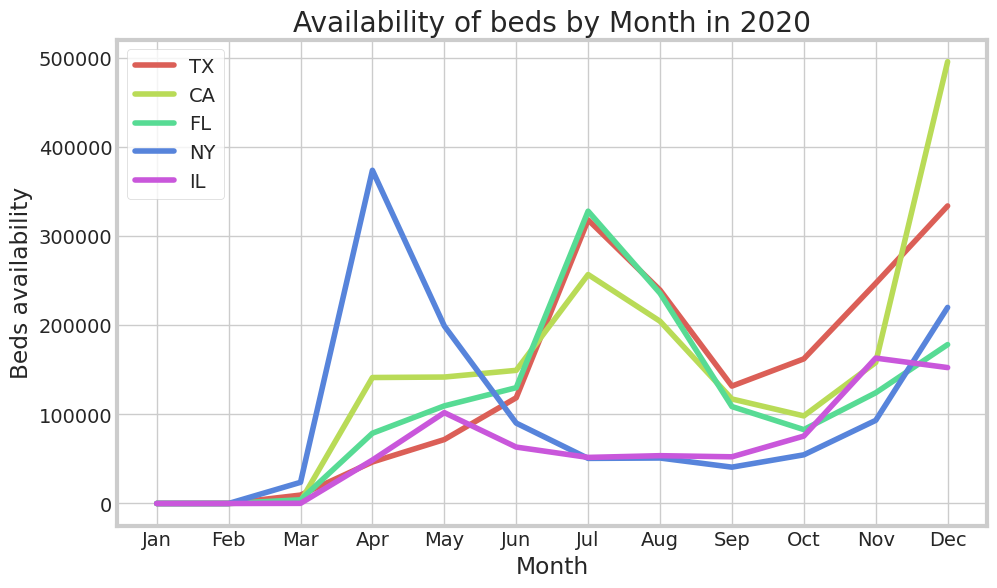

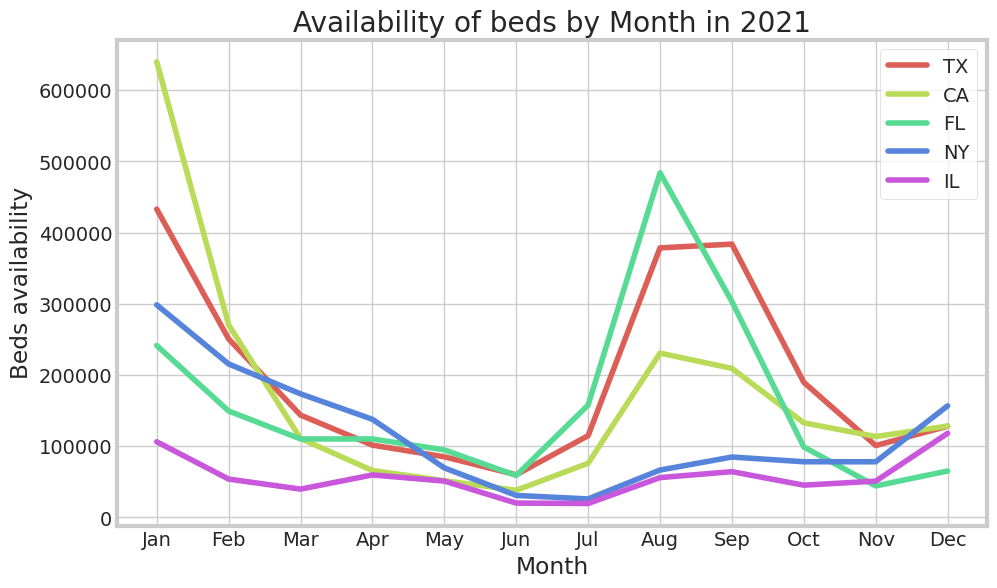

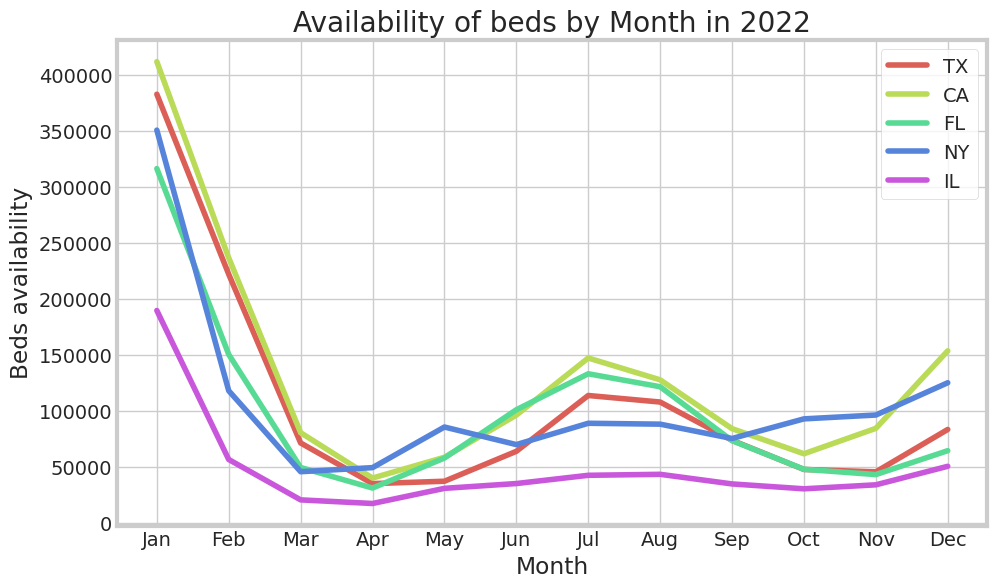

In [158]:
def line_plot(data, year):
  plot_data = data[data.year == year].groupby('month').sum().drop(columns = ['year'])
  # print(plot_data)
  x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
  y = ['TX', 'CA', 'FL', 'NY', 'IL']

  color_palette = sns.color_palette("hls", 5)
  sns.set_style("whitegrid")
  plt.figure(figsize=(10, 6))
  for i, col in enumerate(y):
      plt.plot(x, plot_data[col], color=color_palette[i], label=col)
      
  plt.xlabel('Month')
  plt.ylabel('Beds availability')
  plt.title('Availability of beds by Month in {}'.format(year))
  plt.legend()
  plt.show()

for year in [2020, 2021, 2022]:
  line_plot(state_beds, year)

###Helper function to create train and test split

In [159]:
def create_train_test(data):
  length = len(data)
  tr_len = int(length*0.9)

  train = data.head(tr_len)
  test = data.tail(length-tr_len)
  return train, test

###Helper functions for predictions and plots

In [160]:
def predictions(model, train, test, data):
  test_pred=model.predict(test.index[0],test.index[-1])
  train_pred=model.predict(train.index[0],train.index[-1])
  data_pred=model.predict(0,len(data)-1)

  rmse_test=sqrt(mean_squared_error(test.col, test_pred))
  rmse_train=sqrt(mean_squared_error(train.col, train_pred))
  rmse_data=sqrt(mean_squared_error(data.col, data_pred))

  print('Train RMSE: {}'.format(rmse_train))
  print('Test RMSE: {}'.format(rmse_test))
  print('Data RMSE: {}'.format(rmse_data))

  return train_pred, test_pred

In [214]:
def plot(train_pred, test_pred, train, test, title):
  plt.figure(figsize=(15,5))
  plt.plot(train.col,label='train')
  plt.plot(test.col,label='actual')
  plt.plot(train_pred,label='train_prediction')
  plt.plot(test_pred,label='test_prediction')
  plt.title(title)
  plt.xlabel("Time")
  plt.ylabel("Beds Available")
  plt.legend(loc='best')
  plt.show()

In [162]:
def get_weekwise(data):
  data = pd.DataFrame(data)
  data['week'] = data.index.week
  data = data.groupby('week').sum()
  return data

##State Level Time Series Analysis

In [178]:
def pivot_state(data):
  state_data = pd.pivot_table(data, values='available_beds', index='date', columns='state', aggfunc=np.sum, fill_value=0)
  return state_data

In [179]:
state = 'NY'

In [180]:
state_beds = pivot_state(beds)
beds_ny = state_beds[[state]].rename(columns={state: 'col'})
temp = beds_ny[beds_ny.col==0].size
beds_ny = beds_ny.iloc[temp:]

In [201]:
state_icu_beds = pivot_state(icu_beds)
icu_beds_ny = state_icu_beds[[state]].rename(columns={state: 'col'})
temp = icu_beds_ny[icu_beds_ny.col==0].size
icu_beds_ny = icu_beds_ny.iloc[temp:]

##Beds Availability

###ARIMA model

In [215]:
model_data = beds_ny
train, test = create_train_test(model_data)

In [216]:
arima=ARIMA(train.col,order=(2,0,6)).fit()

Train RMSE: 781.4489115798283
Test RMSE: 1395.2672967802082
Data RMSE: 863.0478817143985


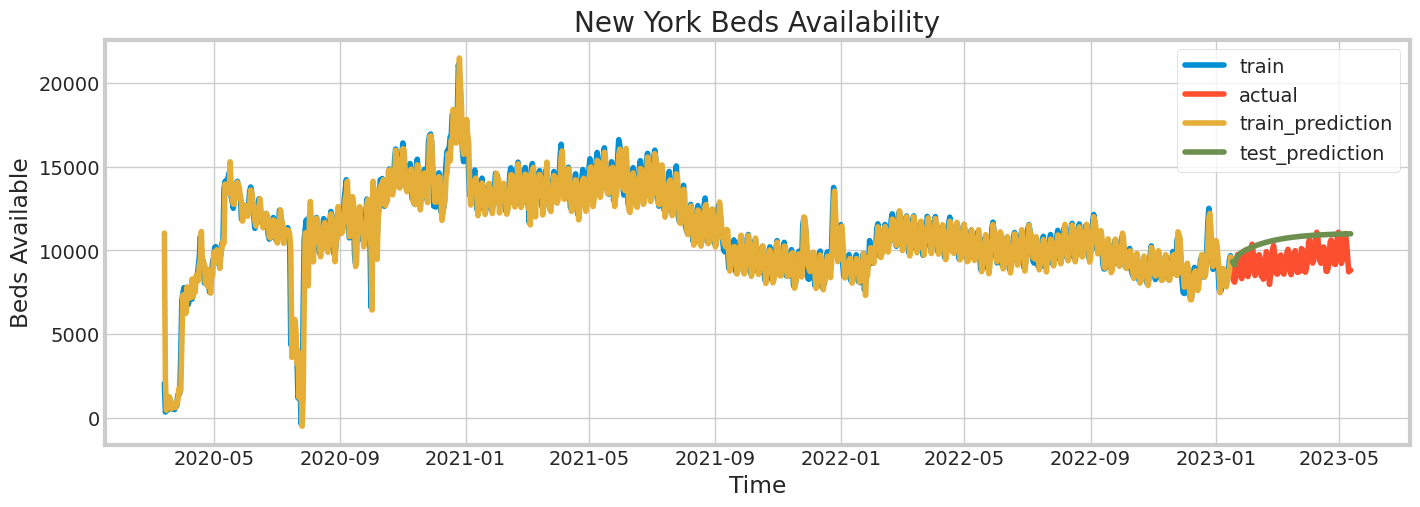

In [217]:
train_pred, test_pred = predictions(arima, train, test, model_data)
plot(train_pred, test_pred, train, test, 'New York Beds Availability')

In [192]:
test = get_weekwise(test)
test_pred = get_weekwise(test_pred)
test.to_csv('state_actual.csv')
test_pred.to_csv('state_preds.csv')

###SARIMA Model

In [218]:
sarima=SARIMAX(train.col,order=(2,0,5),seasonal_order=(2,0,5,7)).fit()

Train RMSE: 597.0227466680259
Test RMSE: 2232.772290247951
Data RMSE: 906.2690434563656


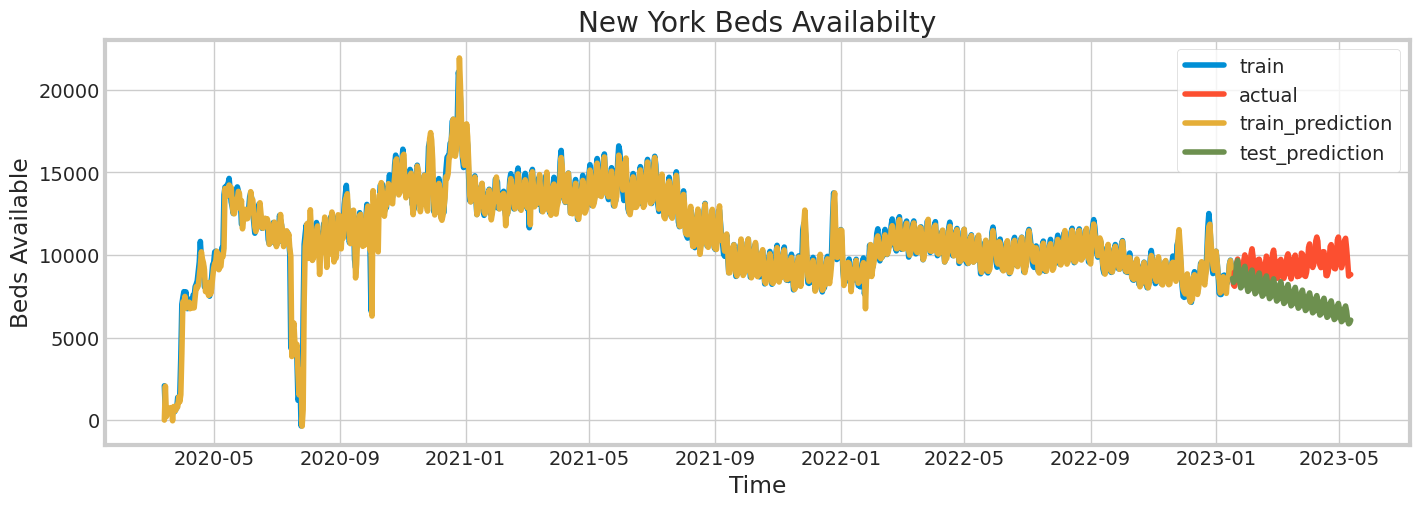

In [219]:
train_pred, test_pred = predictions(sarima, train, test, model_data)
plot(train_pred, test_pred, train, test, 'New York Beds Availabilty')

###Holtz Exponential Smoothing Model

In [220]:
expsm=ExponentialSmoothing(train.col,seasonal="add",seasonal_periods=10).fit()

Train RMSE: 896.3029593807986
Test RMSE: 987.337631783557
Data RMSE: 905.8591986092878


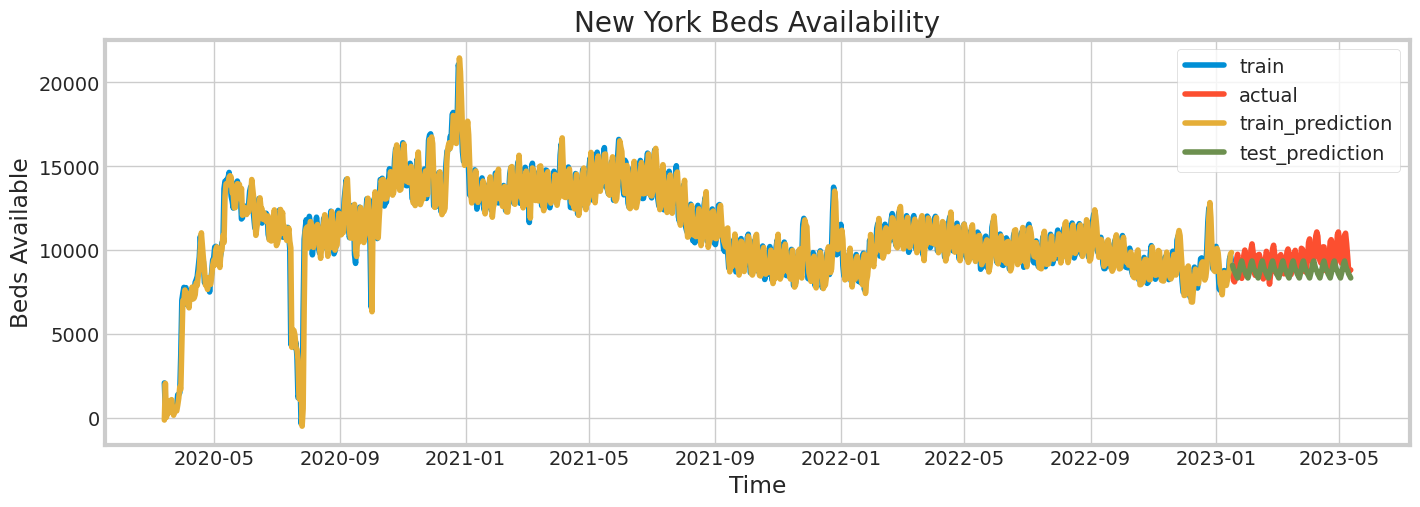

In [221]:
train_pred, test_pred = predictions(expsm, train, test, model_data)
plot(train_pred, test_pred, train, test, 'New York Beds Availability')

##ICU Beds Availability

In [222]:
model_data = icu_beds_ny
train, test = create_train_test(model_data)

In [223]:
arima=ARIMA(train.col,order=(2,0,6)).fit()

Train RMSE: 140.3839169112884
Test RMSE: 157.869389652745
Data RMSE: 142.24344219252896


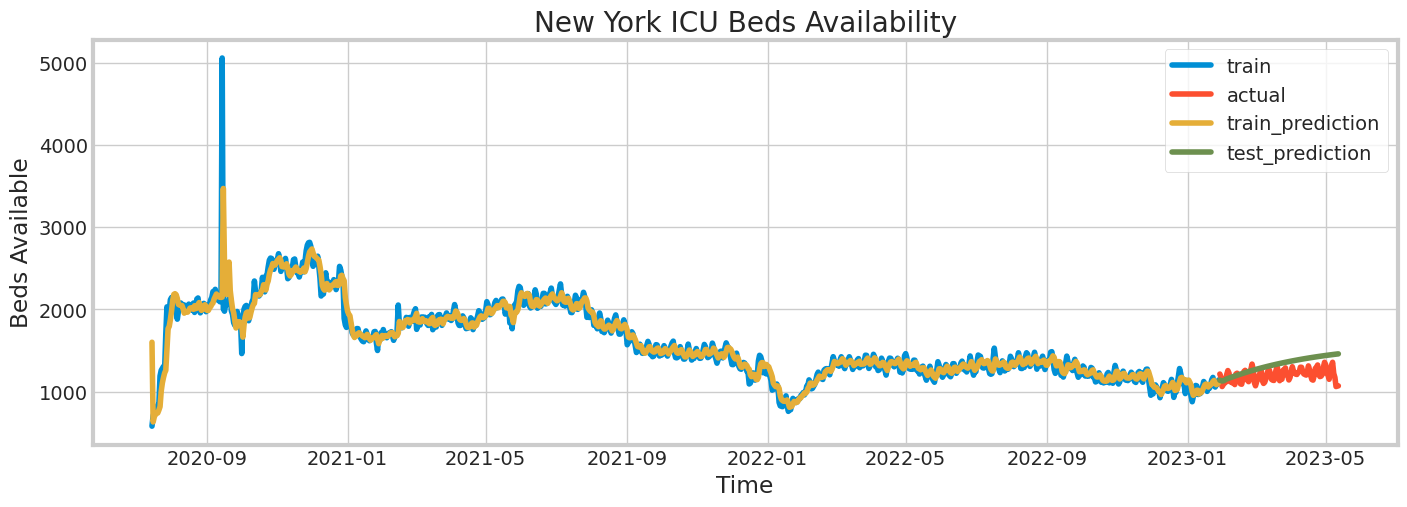

In [224]:
train_pred, test_pred = predictions(arima, train, test, model_data)
plot(train_pred, test_pred, train, test, 'New York ICU Beds Availability')

In [205]:
test = get_weekwise(test)
test_pred = get_weekwise(test_pred)
test.to_csv('state_icu_actual.csv')
test_pred.to_csv('state_icu_preds.csv')

##Country Level Time Series Analysis

In [119]:
def pivot_country(data):
  country_beds = data.groupby(['date']).sum()[['available_beds']].rename(columns={'available_beds':'col'})
  return country_beds

###Beds Availability

In [225]:
country_beds = pivot_country(beds)
model_data = country_beds
train, test = create_train_test(model_data)

In [226]:
arima=ARIMA(train.col,order=(2,0,6)).fit()

Train RMSE: 10745.148149367295
Test RMSE: 14445.616846717929
Data RMSE: 11171.175162466488


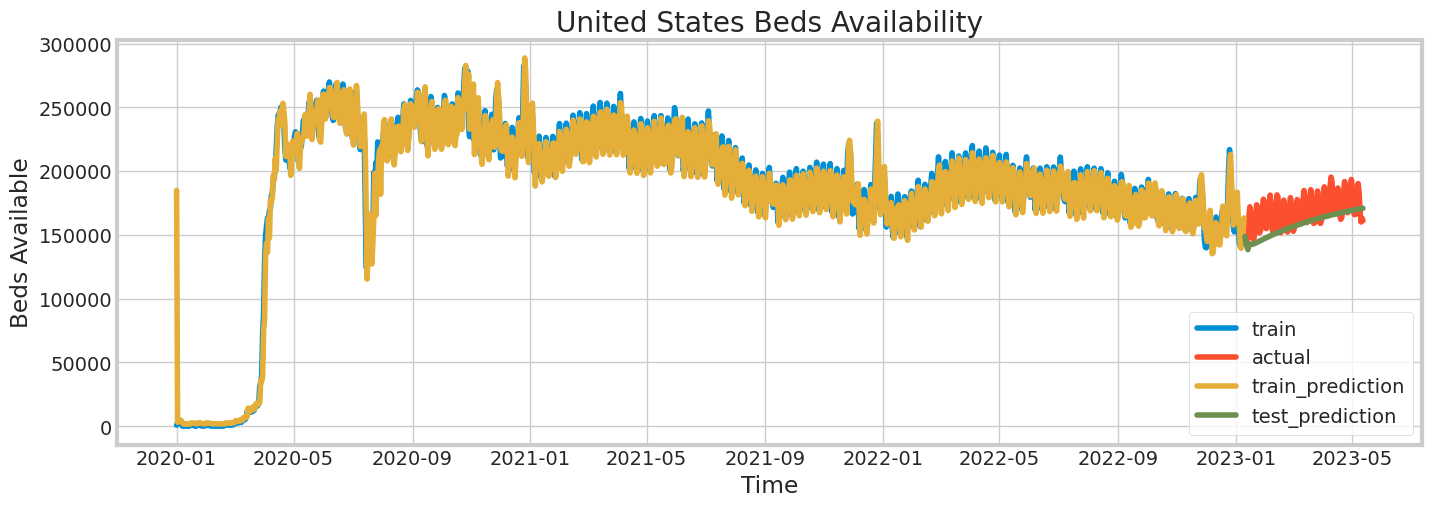

In [227]:
train_pred, test_pred = predictions(arima, train, test, model_data)
plot(train_pred, test_pred, train, test, 'United States Beds Availability')

In [209]:
test = get_weekwise(test)
test_pred = get_weekwise(test_pred)
test.to_csv('county_actual.csv')
test_pred.to_csv('county_pred.csv')

###ICU Beds Availability

In [228]:
icu_country_beds = pivot_country(icu_beds)
model_data = icu_country_beds
train, test = create_train_test(model_data)

In [229]:
arima=ARIMA(train.col,order=(2,0,6)).fit()

Train RMSE: 949.8717949348345
Test RMSE: 3640.8631852839435
Data RMSE: 1462.747841942696


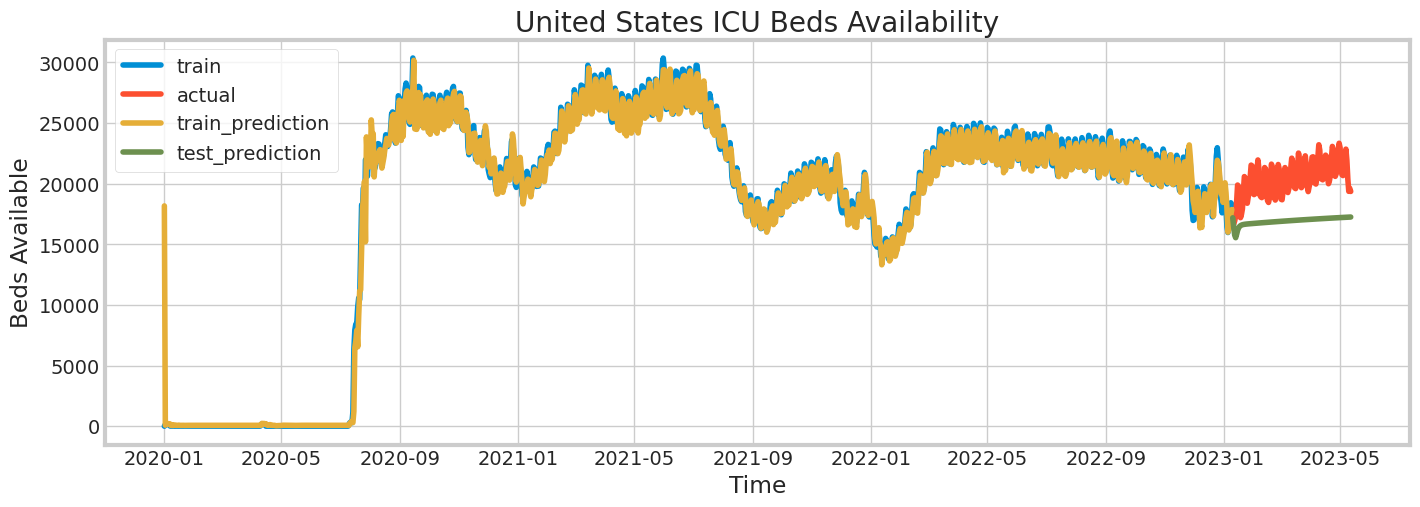

In [230]:
train_pred, test_pred = predictions(arima, train, test, model_data)
plot(train_pred, test_pred, train, test, 'United States ICU Beds Availability')

In [213]:
test = get_weekwise(test)
test_pred = get_weekwise(test_pred)
test.to_csv('county_icu_actual.csv')
test_pred.to_csv('county_icu_pred.csv')